## Conv2d
反复运行多次，观察卷积核卷积后的结果，也可调整Conv2d参数观察输出特征图变化。 

In [1]:
def transform_invert(img_, transform_train):
    """
    将data 进行反transfrom操作
    :param img_: tensor
    :param transform_train: torchvision.transforms
    :return: PIL image
    """
    if 'Normalize' in str(transform_train):
        norm_transform = list(filter(lambda x: isinstance(x, transforms.Normalize), transform_train.transforms))
        mean = torch.tensor(norm_transform[0].mean, dtype=img_.dtype, device=img_.device)
        std = torch.tensor(norm_transform[0].std, dtype=img_.dtype, device=img_.device)
        img_.mul_(std[:, None, None]).add_(mean[:, None, None])

    img_ = img_.transpose(0, 2).transpose(0, 1)  # C*H*W --> H*W*C
    if 'ToTensor' in str(transform_train) or img_.max() < 1:
        img_ = img_.detach().numpy() * 255

    if img_.shape[2] == 3:
        img_ = Image.fromarray(img_.astype('uint8')).convert('RGB')
    elif img_.shape[2] == 1:
        img_ = Image.fromarray(img_.astype('uint8').squeeze())
    else:
        raise Exception("Invalid img shape, expected 1 or 3 in axis 2, but got {}!".format(img_.shape[2]) )

    return img_

卷积前尺寸:torch.Size([1, 3, 4095, 3342])
卷积后尺寸:torch.Size([1, 1, 4093, 3340])


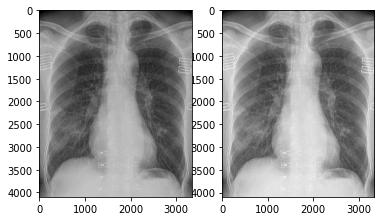

In [2]:
import os
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

# load img
path_img = os.path.join(os.getcwd(), 
                        "..", "..", "data", "datasets", "covid-19-demo", "imgs", "covid-19", "ryct.2020200028.fig1a.jpeg")
img = Image.open(path_img).convert('RGB')  # 0~255
img_transform = transforms.Compose([transforms.ToTensor()]) # convert to tensor
img_tensor = img_transform(img)
img_tensor.unsqueeze_(dim=0)    # C*H*W to B*C*H*W

# define layer
# in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1
conv_layer = nn.Conv2d(3, 1, 3, stride=1, padding=0, dilation=1)   # input:(i, o, size) weights:(o, i , h, w)
# nn.init.xavier_normal_(conv_layer.weight.data)

# forward
img_conv = conv_layer(img_tensor)

# plot
print("卷积前尺寸:{}\n卷积后尺寸:{}".format(img_tensor.shape, img_conv.shape))
img_conv = transform_invert(img_conv[0, 0:1, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_conv, cmap='gray')
plt.subplot(121).imshow(img_raw)
plt.show()

## pooling
尝试修改, kernel_size, stride, padding, dilation, ceil_mode等参数，观察前后差异

### maxpool

池化前尺寸:torch.Size([1, 3, 4095, 3342])
池化后尺寸:torch.Size([1, 3, 2047, 1671])


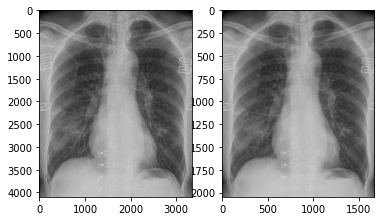

In [3]:
# kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False

maxpool_layer = nn.MaxPool2d((2, 2), stride=(2, 2), return_indices=False, ceil_mode=False) 
img_pool = maxpool_layer(img_tensor)
print("池化前尺寸:{}\n池化后尺寸:{}".format(img_tensor.shape, img_pool.shape))
img_pool = transform_invert(img_pool[0, 0:3, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_pool)
plt.subplot(121).imshow(img_raw)
plt.show()


### MaxUnpool2d

原图尺寸:torch.Size([1, 3, 4095, 3342])
池化前尺寸:torch.Size([1, 3, 2047, 1671])
反池化后尺寸:torch.Size([1, 3, 4094, 3342])


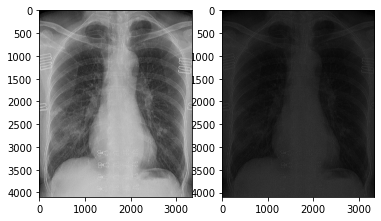

In [4]:
# kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False

maxpool_layer = nn.MaxPool2d((2, 2), stride=(2, 2), return_indices=True, ceil_mode=False) 
img_pool, indices = maxpool_layer(img_tensor)

# MaxUnpool2d
maxunpool_layer = nn.MaxUnpool2d(2, stride=2)
img_pool_unpool = maxunpool_layer(img_pool, indices)


print("原图尺寸:{}\n池化前尺寸:{}\n反池化后尺寸:{}".format(img_tensor.shape, img_pool.shape, img_pool_unpool.shape))
img_pool_unpool = transform_invert(img_pool_unpool[0, 0:3, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_pool_unpool)
plt.subplot(121).imshow(img_raw)
plt.show()


## AdaptiveMaxPool2d
尝试多次修改输入数据的size，再观察池化后的size

原图尺寸:torch.Size([1, 3, 4095, 3342])
池化前尺寸:torch.Size([1, 3, 1024, 1024])


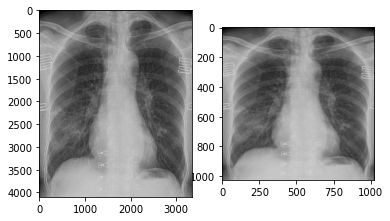

In [5]:

ada_maxpool_layer = nn.AdaptiveMaxPool2d((1024,1024))
img_pool = ada_maxpool_layer(img_tensor)

print("原图尺寸:{}\n池化前尺寸:{}".format(img_tensor.shape, img_pool.shape))
img_pool = transform_invert(img_pool[0, 0:3, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_pool)
plt.subplot(121).imshow(img_raw)
plt.show()


## ReflectionPad2d
镜像填充

原图尺寸:torch.Size([1, 3, 4095, 3342])
池化前尺寸:torch.Size([1, 3, 5119, 4366])


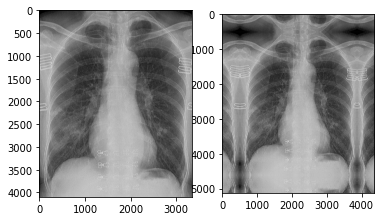

In [6]:

pad2d = nn.ReflectionPad2d(512)
img_pool = pad2d(img_tensor)

print("原图尺寸:{}\n池化前尺寸:{}".format(img_tensor.shape, img_pool.shape))
img_pool = transform_invert(img_pool[0, 0:3, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_pool)
plt.subplot(121).imshow(img_raw)
plt.show()


## ReplicationPad2d
边界重复值填充

原图尺寸:torch.Size([1, 3, 4095, 3342])
池化前尺寸:torch.Size([1, 3, 5119, 4366])


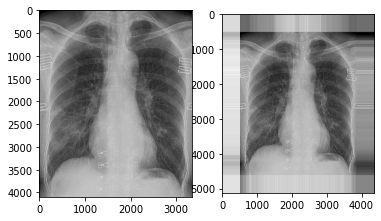

In [7]:

pad2d = nn.ReplicationPad2d(512)
img_pool = pad2d(img_tensor)

print("原图尺寸:{}\n池化前尺寸:{}".format(img_tensor.shape, img_pool.shape))
img_pool = transform_invert(img_pool[0, 0:3, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_pool)
plt.subplot(121).imshow(img_raw)
plt.show()


## ZeroPad2d
零值填充

原图尺寸:torch.Size([1, 3, 4095, 3342])
池化前尺寸:torch.Size([1, 3, 5119, 4366])


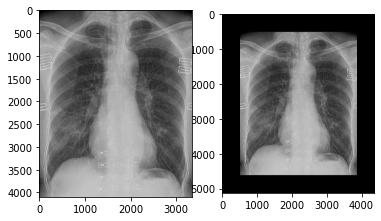

In [8]:

pad2d = nn.ZeroPad2d(512)
img_pool = pad2d(img_tensor)

print("原图尺寸:{}\n池化前尺寸:{}".format(img_tensor.shape, img_pool.shape))
img_pool = transform_invert(img_pool[0, 0:3, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_pool)
plt.subplot(121).imshow(img_raw)
plt.show()


## ConstantPad2d
指定值填充

原图尺寸:torch.Size([1, 3, 4095, 3342])
池化前尺寸:torch.Size([1, 3, 5119, 4366])


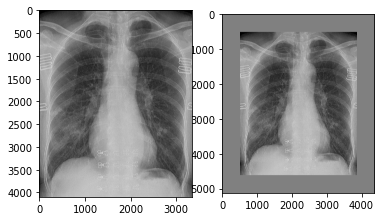

In [9]:

pad2d = nn.ConstantPad2d(512, 128)
img_pool = pad2d(img_tensor)

print("原图尺寸:{}\n池化前尺寸:{}".format(img_tensor.shape, img_pool.shape))
img_pool = transform_invert(img_pool[0, 0:3, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_pool)
plt.subplot(121).imshow(img_raw)
plt.show()


## BatchNorm 2d
* 观察BN层四个参数的shape，与什么有关
* 观察BN层输出为什么是0？提示：参照[公式](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d)计算

In [10]:
import torch

batch_size = 3
num_features = 6
momentum = 0.3

features_shape = (2, 2)

feature_map = torch.ones(features_shape)                                                     # 2D
feature_maps = torch.stack([feature_map*(i+1) for i in range(num_features)], dim=0)         # 3D
feature_maps_bs = torch.stack([feature_maps for i in range(batch_size)], dim=0)             # 4D

print("input data:\n{} shape is {}".format(feature_maps_bs, feature_maps_bs.shape))

bn = nn.BatchNorm2d(num_features=num_features, momentum=momentum)

running_mean, running_var = 0, 1

for i in range(2):
    outputs = bn(feature_maps_bs)

    print("\niter:{}, running_mean.shape: {}".format(i, bn.running_mean.shape))
    print("iter:{}, running_var.shape: {}".format(i, bn.running_var.shape))

    print("iter:{}, weight.shape: {}".format(i, bn.weight.shape))
    print("iter:{}, bias.shape: {}".format(i, bn.bias.shape))
    
    print("\noutputs:{}".format(outputs))

input data:
tensor([[[[1., 1.],
          [1., 1.]],

         [[2., 2.],
          [2., 2.]],

         [[3., 3.],
          [3., 3.]],

         [[4., 4.],
          [4., 4.]],

         [[5., 5.],
          [5., 5.]],

         [[6., 6.],
          [6., 6.]]],


        [[[1., 1.],
          [1., 1.]],

         [[2., 2.],
          [2., 2.]],

         [[3., 3.],
          [3., 3.]],

         [[4., 4.],
          [4., 4.]],

         [[5., 5.],
          [5., 5.]],

         [[6., 6.],
          [6., 6.]]],


        [[[1., 1.],
          [1., 1.]],

         [[2., 2.],
          [2., 2.]],

         [[3., 3.],
          [3., 3.]],

         [[4., 4.],
          [4., 4.]],

         [[5., 5.],
          [5., 5.]],

         [[6., 6.],
          [6., 6.]]]]) shape is torch.Size([3, 6, 2, 2])

iter:0, running_mean.shape: torch.Size([6])
iter:0, running_var.shape: torch.Size([6])
iter:0, weight.shape: torch.Size([6])
iter:0, bias.shape: torch.Size([6])

outputs:tensor([[[[0., 0.],
  

## Dropout

设计一个10000个输入，1个输出的Linear层，观察Linear层这个神经元输出的值。  
请多运行几次，观察训练模式下的值，思考为什么会是这些值


In [12]:

class Net(nn.Module):
    def __init__(self, neural_num, d_prob=0.5):
        super(Net, self).__init__()

        self.linears = nn.Sequential(
            nn.Dropout(d_prob),
            nn.Linear(neural_num, 1, bias=False),
            nn.ReLU(inplace=True))

    def forward(self, x):
        return self.linears(x)

input_num = 10000  
x = torch.ones((input_num, ), dtype=torch.float32)

net = Net(input_num, d_prob=0.5)
net.linears[1].weight.detach().fill_(1.)

net.train()
y = net(x)
print("output in training mode", y)

net.eval()
y = net(x)
print("output in eval mode", y)

output in training mode tensor([10042.], grad_fn=<ReluBackward0>)
output in eval mode tensor([10000.], grad_fn=<ReluBackward0>)
